# Análisis Exploratorio de Datos (EDA) – Turismo en España

**Primera Entrega** : Aprendizaje Automático

El objetivo es realizar un análisis exploratorio de datos (EDA) sobre información turística de España, combinando:

- Datos de viajeros/pernoctaciones por provincia (EOH – Encuesta de Ocupación Hotelera)
- Datos de movimientos turísticos internos por provincia de destino (TMOV).



## 1. Problema de negocio

El turismo es uno de los principales motores económicos de España y el poder conocer qué provincias reciben más turista, en qué épocas del año y cómo se comportan las pernoctaciones es clave para:

- Planificación de recursos (hoteles, transporte, etc).
- Marketing turístico
- Toma de decisiones públicas y privadas

En este trabajo estudiamos:

- ¿Cómo se distribuye el turismo en España por provincia y por temporada (invierno, primavera, verano, otoño)?
- ¿Qué provincias concentran más turistas y pernoctaciones en cada época del año?

A través de este trabajo podremos:
- Detectar comportamientos tanto territoriales como temporales


## 2. Origen de los datoss 


Se utilizan dos fuentes oficiales INE:

- EOH (Encuesta de Ocupación Hotelera). Datos mensuales de viajeros y pernoctaciones por provincia. 
  - Provincias
  - Viajeros y pernoctaciones
  - Periodo
  - Total 

- TMOV (Movimiento turístico de residentes). Datos de número de turistas por provincia de destino, desagregados por provincia de origen y periodo.  
  - Provincia de origen
  - CCAA y provincia de destino
  - Concepto turístico
  - Periodo
  - Total

Ambos datasets se descargaron en formato CSV desde fuentes oficiales (INE / Datos.gob.es) y se combinan para obtener una visión mas amplia del turismo por provincia y temporada


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# datasets
ruta_eoh = "per.csv" 
ruta_tmov = "turistas.csv"        

df_eoh = pd.read_csv(ruta_eoh, sep=';')
df_tmov = pd.read_csv(ruta_tmov, sep=';')


print("EOH columns:", df_eoh.columns)
print("TMOV columns:", df_tmov.columns)


C:\Users\User\AppData\Local\Temp\ipykernel_1856\1121794345.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_eoh = pd.read_csv(ruta_eoh, sep=';')


EOH columns: Index(['Totales Territoriales', 'Comunidades y Ciudades Autónomas',
       'Provincias', 'Viajeros y pernoctaciones', 'Residencia: Nivel 1',
       'Residencia: Nivel 2', 'Periodo', 'Total'],
      dtype='object')
TMOV columns: Index(['Provincia de origen', 'Provincia de origen.1',
       'CCAA y provincia de destino', 'CCAA y provincia de destino.1',
       'CCAA y provincia de destino.2', 'Concepto turístico', 'Period',
       'Total'],
      dtype='object')


### Preparación de datos

- Renombramos columnas para que tengan nombres sencillos
- Convertimos algunos valores a tipo numérico
- Creamos variables temporales (año, mes, temporada)
- En el caso de TMOV, construimos una provincia de destino final a partir de los niveles de detalle


In [3]:
df_tmov = df_tmov.rename(columns={
    'Provincia de origen': 'provincia_origen',
    'Provincia de origen.1': 'provincia_origen_detalle',
    'CCAA y provincia de destino': 'provincia_destino',
    'CCAA y provincia de destino.1': 'provincia_destino_detalle_1',
    'CCAA y provincia de destino.2': 'provincia_destino_detalle_2',
    'Concepto turístico': 'concepto_turistico',
    'Period': 'periodo',
    'Total': 'num_turistas'
})



In [4]:
df_tmov['num_turistas'] = (
    df_tmov['num_turistas']
    .astype(str)
    .str.replace('.', '', regex=False)   
    .str.replace(',', '.', regex=False)  
)
df_tmov['num_turistas'] = pd.to_numeric(df_tmov['num_turistas'], errors='coerce')


In [5]:
df_tmov['provincia_final'] = df_tmov['provincia_destino_detalle_2']
df_tmov['provincia_final'] = df_tmov['provincia_final'].fillna(df_tmov['provincia_destino_detalle_1'])
df_tmov['provincia_final'] = df_tmov['provincia_final'].fillna(df_tmov['provincia_destino'])


In [6]:
# v temporales
df_tmov['año'] = df_tmov['periodo'].str[:4].astype(int)
df_tmov['mes'] = df_tmov['periodo'].str[-2:].astype(int)


def temporada(mes):
    if mes in [6, 7, 8]:
        return 'verano'
    elif mes in [12, 1, 2]:
        return 'invierno'
    elif mes in [3, 4, 5]:
        return 'primavera'
    else:
        return 'otoño'

df_tmov['temporada'] = df_tmov['mes'].apply(temporada)

df_tmov.head()


,provincia_origen,provincia_origen_detalle,provincia_destino,provincia_destino_detalle_1,provincia_destino_detalle_2,concepto_turistico,periodo,num_turistas,provincia_final,año,mes,temporada
0,Total Nacional,NaN,Total Nacional,NaN,NaN,Turistas,2025M08,NaN,Total Nacional,2025,8,verano
1,Total Nacional,NaN,Total Nacional,NaN,NaN,Turistas,2025M07,NaN,Total Nacional,2025,7,verano
2,Total Nacional,NaN,Total Nacional,NaN,NaN,Turistas,2025M06,NaN,Total Nacional,2025,6,verano
3,Total Nacional,NaN,Total Nacional,NaN,NaN,Turistas,2025M05,NaN,Total Nacional,2025,5,primavera
4,Total Nacional,NaN,Total Nacional,NaN,NaN,Turistas,2025M04,NaN,Total Nacional,2025,4,primavera


In [7]:

df_eoh = df_eoh.rename(columns={
    'Provincias': 'provincia',
    'Total': 'total_eoh',
    'Periodo': 'periodo'
})

#  total_eoh a numérico
df_eoh['total_eoh'] = (
    df_eoh['total_eoh']
    .astype(str)
    .str.replace('.', '', regex=False)
    .str.replace(',', '.', regex=False)
)
df_eoh['total_eoh'] = pd.to_numeric(df_eoh['total_eoh'], errors='coerce')

# v temporales
df_eoh['año'] = df_eoh['periodo'].str[:4].astype(int)
df_eoh['mes'] = df_eoh['periodo'].str[-2:].astype(int)
df_eoh['temporada'] = df_eoh['mes'].apply(temporada)

df_eoh.head()


,Totales Territoriales,Comunidades y Ciudades Autónomas,provincia,Viajeros y pernoctaciones,Residencia: Nivel 1,Residencia: Nivel 2,periodo,total_eoh,año,mes,temporada
0,Total Nacional,NaN,NaN,Viajero,Total,NaN,2025M09,12050972.0,2025,9,otoño
1,Total Nacional,NaN,NaN,Viajero,Total,NaN,2025M08,13828672.0,2025,8,verano
2,Total Nacional,NaN,NaN,Viajero,Total,NaN,2025M07,13044764.0,2025,7,verano
3,Total Nacional,NaN,NaN,Viajero,Total,NaN,2025M06,12256716.0,2025,6,verano
4,Total Nacional,NaN,NaN,Viajero,Total,NaN,2025M05,11803477.0,2025,5,primavera


### Merge

Combinación de EOH y TMOV

Se convinan ambos datasets para analizar uno solo EDA:

- Pernoctaciones / viajeros por provincia (total_eoh)
- Turistas por provincia de destino (num_turistas)
- Variables temporales (año, mes, temporada)

Con un LEFT JOIN, usando EOH como base, para no perder provincias


In [8]:
df_eda = pd.merge(
    df_eoh,
    df_tmov[['provincia_final', 'año', 'mes', 'num_turistas']],
    how='left',
    left_on=['provincia', 'año', 'mes'],
    right_on=['provincia_final', 'año', 'mes']
)

df_eda = df_eda.drop(columns=['provincia_final'])

df_eda.head(), df_eda.shape


(  Totales Territoriales Comunidades y Ciudades Autónomas provincia  \
 0        Total Nacional                              NaN       NaN   
 1        Total Nacional                              NaN       NaN   
 2        Total Nacional                              NaN       NaN   
 3        Total Nacional                              NaN       NaN   
 4        Total Nacional                              NaN       NaN   
 
   Viajeros y pernoctaciones Residencia: Nivel 1 Residencia: Nivel 2  periodo  \
 0                   Viajero               Total                 NaN  2025M09   
 1                   Viajero               Total                 NaN  2025M08   
 2                   Viajero               Total                 NaN  2025M07   
 3                   Viajero               Total                 NaN  2025M06   
 4                   Viajero               Total                 NaN  2025M05   
 
     total_eoh   año  mes  temporada  num_turistas  
 0  12050972.0  2025    9      

## Detección de errores o inconsistencias

In [9]:
porcentaje_nulos = df_eda.isnull().mean().sort_values(ascending=False) * 100
porcentaje_nulos


num_turistas                        100.000000
Residencia: Nivel 2                  33.333333
provincia                            28.571429
Comunidades y Ciudades Autónomas      1.428571
total_eoh                             0.063047
Totales Territoriales                 0.000000
Viajeros y pernoctaciones             0.000000
Residencia: Nivel 1                   0.000000
periodo                               0.000000
año                                   0.000000
mes                                   0.000000
temporada                             0.000000
dtype: float64

In [10]:
print("Valores negativos:")
(df_eda[['total_eoh','num_turistas']] < 0).sum()


Valores negativos:


total_eoh       0
num_turistas    0
dtype: int64

In [11]:
# copia limpia para el EDA
df_eda_lim = df_eda.copy()

df_eda_lim = df_eda_lim[df_eda_lim['total_eoh'].notnull()]


df_eda_lim.shape


(134735, 12)

## Análisis de tipo de datos

In [12]:
print("Tipos de datos:")
df_eda_lim.dtypes


Tipos de datos:


Totales Territoriales                object
Comunidades y Ciudades Autónomas     object
provincia                            object
Viajeros y pernoctaciones            object
Residencia: Nivel 1                  object
Residencia: Nivel 2                  object
periodo                              object
total_eoh                           float64
año                                   int64
mes                                   int64
temporada                            object
num_turistas                        float64
dtype: object

In [13]:
print("\nColumnas numéricas:")
df_eda_lim.select_dtypes(include=['int64','float64']).columns



Columnas numéricas:


Index(['total_eoh', 'año', 'mes', 'num_turistas'], dtype='object')

In [14]:
print("\nColumnas categóricas:")
df_eda_lim.select_dtypes(include=['object']).columns



Columnas categóricas:


Index(['Totales Territoriales', 'Comunidades y Ciudades Autónomas',
       'provincia', 'Viajeros y pernoctaciones', 'Residencia: Nivel 1',
       'Residencia: Nivel 2', 'periodo', 'temporada'],
      dtype='object')

In [15]:
#  provincia a categoría
df_eda_lim['provincia'] = df_eda_lim['provincia'].astype('category')


## Tratamiento de outliers

In [16]:
def detectar_outliers(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    limite_inf = Q1 - 1.5 * IQR
    limite_sup = Q3 + 1.5 * IQR
    return (col < limite_inf) | (col > limite_sup)

out_total_eoh = detectar_outliers(df_eda['total_eoh'])
out_turistas = detectar_outliers(df_eda['num_turistas'])

print("Outliers total_eoh:", out_total_eoh.sum())
print("Outliers num_turistas:", out_turistas.sum())


Outliers total_eoh: 18067
Outliers num_turistas: 0


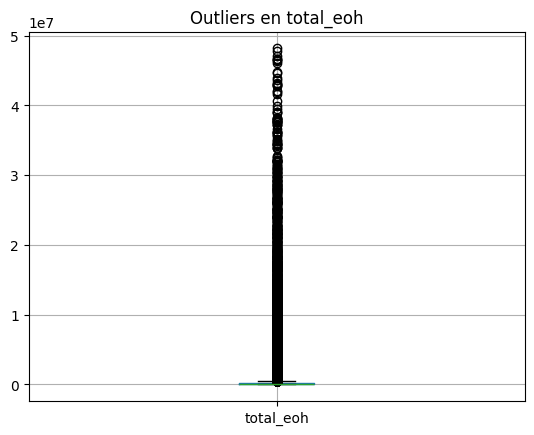

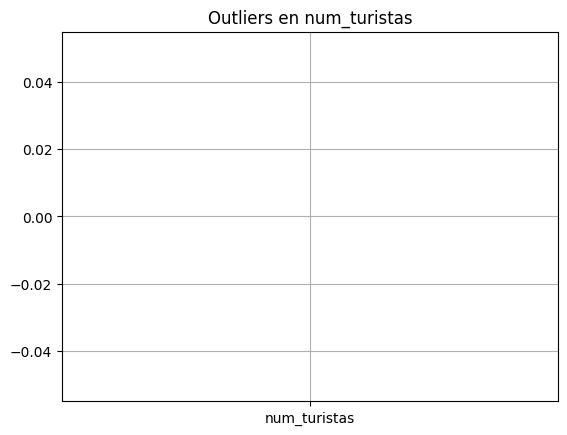

In [17]:
plt.figure()
df_eda.boxplot(column='total_eoh')
plt.title("Outliers en total_eoh")
plt.show()

plt.figure()
df_eda.boxplot(column='num_turistas')
plt.title("Outliers en num_turistas")
plt.show()


In [18]:
#Limpieza EDA

df_eda_lim = df_eda_lim[~out_total_eoh & ~out_turistas].copy()


C:\Users\User\AppData\Local\Temp\ipykernel_1856\1217742507.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_eda_lim = df_eda_lim[~out_total_eoh & ~out_turistas].copy()


## Analisis Exploratorio (df_eda_lim)

### Análisis  univariante

Analizamos la distribución de las principales variables numéricas:

- total_eoh (viajeros/pernoctaciones)
- num_turistas (turistas TMOV)


In [19]:
df_eda_lim[['total_eoh', 'num_turistas']].describe()


,total_eoh,num_turistas
count,116668.000000,0.0
mean,98312.333690,NaN
std,112146.844585,NaN
min,0.000000,NaN
25%,20913.000000,NaN
50%,54823.500000,NaN
75%,132081.250000,NaN
max,520773.000000,NaN


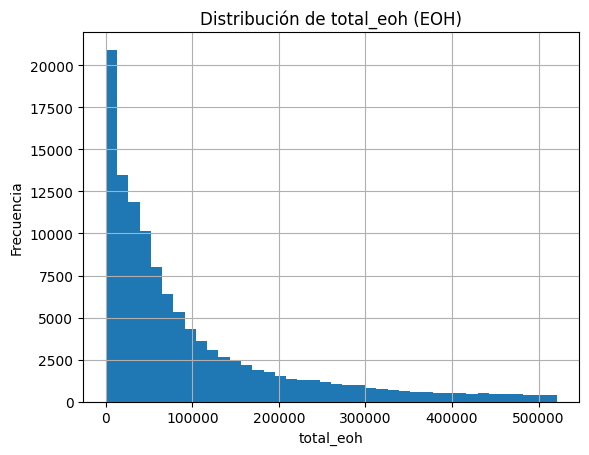

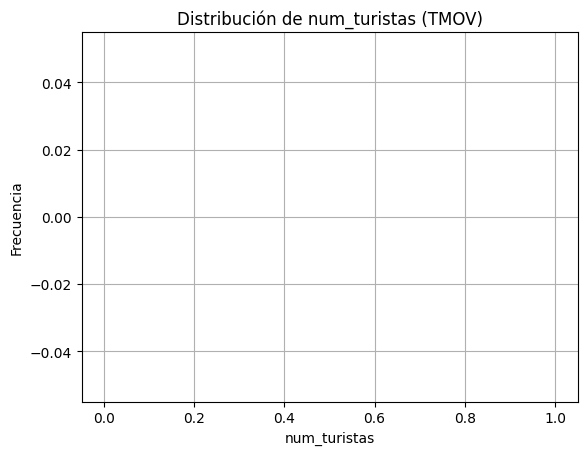

In [20]:
plt.figure()
df_eda_lim['total_eoh'].hist(bins=40)
plt.title("Distribución de total_eoh (EOH)")
plt.xlabel("total_eoh")
plt.ylabel("Frecuencia")
plt.show()

plt.figure()
df_eda_lim['num_turistas'].hist(bins=40)
plt.title("Distribución de num_turistas (TMOV)")
plt.xlabel("num_turistas")
plt.ylabel("Frecuencia")
plt.show()


### Análisis por provincia y temporada

Queremos saber:

- Qué provincias reciben más turismo en verano
- Qué provincias destacan en invierno
- Cómo se distribuyen los turistas por temporadas

 usamos principalmente `df_tmov`, donde la col `provincia_final` contiene las provincias reales de destino

In [21]:
df_temporada = (
    df_tmov
    .groupby(['provincia_final', 'temporada'], as_index=False)
    .agg({'num_turistas': 'sum'})
)

df_temporada.head()


,provincia_final,temporada,num_turistas
0,Albacete,invierno,195649.384
1,Albacete,otoño,214384.455
2,Albacete,primavera,209752.831
3,Albacete,verano,227453.051
4,Alicante/Alacant,invierno,164127.986


Verano

In [22]:
top_verano = (
    df_temporada[df_temporada['temporada'] == 'verano']
    .sort_values('num_turistas', ascending=False)
    .head(10)
)
top_verano

,provincia_final,temporada,num_turistas
211,"Rioja, La",verano,582999.058
131,Guadalajara,verano,377025.671
223,Segovia,verano,313254.880
39,"Balears, Illes",verano,310627.528
59,Cantabria,verano,307118.736
155,Lugo,verano,306557.921
19,Araba/Álava,verano,298415.023
219,Santa Cruz de Tenerife,verano,292718.120
231,Soria,verano,291040.482
95,Cuenca,verano,289903.082


In [23]:
top_invierno = (
    df_temporada[df_temporada['temporada'] == 'invierno']
    .sort_values('num_turistas', ascending=False)
    .head(10)
)

top_invierno


,provincia_final,temporada,num_turistas
208,"Rioja, La",invierno,503629.958
56,Cantabria,invierno,492719.120
36,"Balears, Illes",invierno,457863.888
128,Guadalajara,invierno,347283.588
220,Segovia,invierno,290127.906
16,Araba/Álava,invierno,268753.740
264,Ávila,invierno,267744.444
96,Cáceres,invierno,260430.057
148,Lleida,invierno,258177.346
120,Girona,invierno,258035.722


<Figure size 640x480 with 0 Axes>

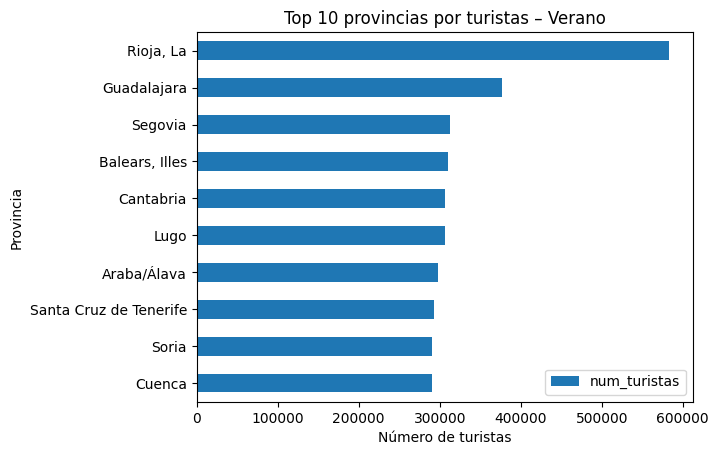

In [24]:
plt.figure()
top_verano.plot(kind='barh', x='provincia_final', y='num_turistas')
plt.gca().invert_yaxis()
plt.title("Top 10 provincias por turistas – Verano")
plt.xlabel("Número de turistas")
plt.ylabel("Provincia")
plt.show()


<Figure size 640x480 with 0 Axes>

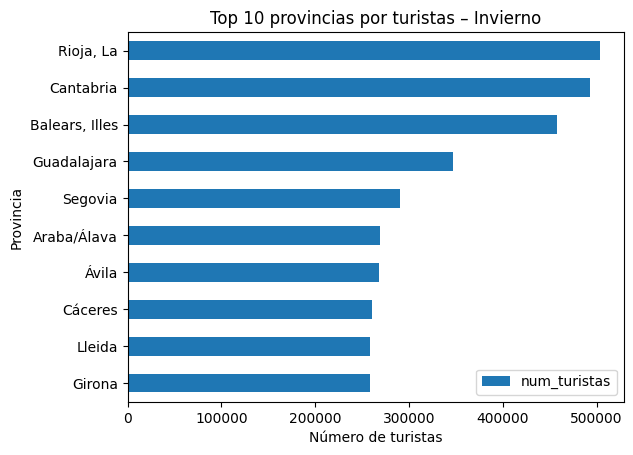

In [25]:
plt.figure()
top_invierno.plot(kind='barh', x='provincia_final', y='num_turistas')
plt.gca().invert_yaxis()
plt.title("Top 10 provincias por turistas – Invierno")
plt.xlabel("Número de turistas")
plt.ylabel("Provincia")
plt.show()


### Resumen

In [26]:
resumen = df_eda_lim.groupby('temporada')[['total_eoh','num_turistas']].sum()
resumen


,total_eoh,num_turistas
temporada,,
invierno,2.395181e+09,0.0
otoño,2.928874e+09,0.0
primavera,2.937879e+09,0.0
verano,3.207970e+09,0.0


Analizados los datos de turismo los resultados por provincia no tienen ningún sentido lógico. Por ejemplo, en el top 10 provincias por verano, es practicamente imposible que Baleares se sitúe por debajo de provincias como La Rioja, Guadalajara o Segovia. Y otras como Barcelona, Valencia o Málaga no aparezcan.

Se intenta encontrar el error.

In [27]:
df_temporada[df_temporada.duplicated()]


,provincia_final,temporada,num_turistas


In [28]:
df_temporada.dtypes

provincia_final     object
temporada           object
num_turistas       float64
dtype: object

In [29]:
df_temporada.head()

,provincia_final,temporada,num_turistas
0,Albacete,invierno,195649.384
1,Albacete,otoño,214384.455
2,Albacete,primavera,209752.831
3,Albacete,verano,227453.051
4,Alicante/Alacant,invierno,164127.986


In [30]:
df_temporada['temporada'].unique()

array(['invierno', 'otoño', 'primavera', 'verano'], dtype=object)

El DataSet "turistas.csv" contempla desplazados turísticos de residentes, por lo que se ha procedido a analizar ambos datasets por separado. El primer dataset "per.csv" muestra resultados razonables con la actividad turística española. En el segunda dataset se ecnuentran tres columnas de provincias de destino ("provincia_destino, provincia_destino_detalle_1, provincia_destino_detalle_2"). La primera columna unicamente especifíca Total Nacional, y las dos siguientes muestran resultados distintos por provincias.

In [31]:
df_eoh.head()

,Totales Territoriales,Comunidades y Ciudades Autónomas,provincia,Viajeros y pernoctaciones,Residencia: Nivel 1,Residencia: Nivel 2,periodo,total_eoh,año,mes,temporada
0,Total Nacional,NaN,NaN,Viajero,Total,NaN,2025M09,12050972.0,2025,9,otoño
1,Total Nacional,NaN,NaN,Viajero,Total,NaN,2025M08,13828672.0,2025,8,verano
2,Total Nacional,NaN,NaN,Viajero,Total,NaN,2025M07,13044764.0,2025,7,verano
3,Total Nacional,NaN,NaN,Viajero,Total,NaN,2025M06,12256716.0,2025,6,verano
4,Total Nacional,NaN,NaN,Viajero,Total,NaN,2025M05,11803477.0,2025,5,primavera


Se comprueban los valores nulos en df_eoh, y se imputan los valores nulos de la columna "total_eoh" con la media aritmética de tusístas de su correspondiente provincia y mes.

In [32]:
df_eoh.isnull().sum().sort_values(ascending=False)

Residencia: Nivel 2                 44940
provincia                           38520
Comunidades y Ciudades Autónomas     1926
total_eoh                              85
Totales Territoriales                   0
Residencia: Nivel 1                     0
Viajeros y pernoctaciones               0
periodo                                 0
año                                     0
mes                                     0
temporada                               0
dtype: int64

In [33]:
df_eoh[df_eoh['total_eoh'].isnull()]

,Totales Territoriales,Comunidades y Ciudades Autónomas,provincia,Viajeros y pernoctaciones,Residencia: Nivel 1,Residencia: Nivel 2,periodo,total_eoh,año,mes,temporada
8379,Total Nacional,01 Andalucía,14 Córdoba,Viajero,Total,Residentes en el Extranjero,2022M12,NaN,2022,12,invierno
46287,Total Nacional,07 Castilla y León,05 Ávila,Viajero,Total,NaN,2020M06,NaN,2020,6,verano
46288,Total Nacional,07 Castilla y León,05 Ávila,Viajero,Total,NaN,2020M05,NaN,2020,5,primavera
46608,Total Nacional,07 Castilla y León,05 Ávila,Viajero,Total,Residentes en España,2020M06,NaN,2020,6,verano
46609,Total Nacional,07 Castilla y León,05 Ávila,Viajero,Total,Residentes en España,2020M05,NaN,2020,5,primavera
...,...,...,...,...,...,...,...,...,...,...,...
133921,Total Nacional,19 Melilla,NaN,Pernoctaciones,Total,NaN,2020M05,NaN,2020,5,primavera
134241,Total Nacional,19 Melilla,NaN,Pernoctaciones,Total,Residentes en España,2020M06,NaN,2020,6,verano
134242,Total Nacional,19 Melilla,NaN,Pernoctaciones,Total,Residentes en España,2020M05,NaN,2020,5,primavera
134562,Total Nacional,19 Melilla,NaN,Pernoctaciones,Total,Residentes en el Extranjero,2020M06,NaN,2020,6,verano


In [34]:
df_eoh[df_eoh['total_eoh'].isnull()].groupby(['provincia', 'mes']).size()

provincia    mes
05 Ávila     5      6
             6      6
14 Córdoba   12     1
24 León      5      6
             6      6
34 Palencia  5      6
             6      6
40 Segovia   5      6
             6      6
49 Zamora    5      6
             6      6
dtype: int64

In [35]:
media = df_eoh.groupby(['provincia', 'mes'])['total_eoh'].transform('mean')

df_eoh['total_eoh'] = df_eoh['total_eoh'].fillna(media)



In [36]:
print(df_eoh['total_eoh'].isnull().sum())


24


Ahora, se detectan 24 valores nulos en la columna mes.

In [37]:
df_eoh[df_eoh['total_eoh'].isnull()].groupby('mes').size()

mes
5    12
6    12
dtype: int64

In [38]:
df_eoh[df_eoh['total_eoh'].isnull()]

,Totales Territoriales,Comunidades y Ciudades Autónomas,provincia,Viajeros y pernoctaciones,Residencia: Nivel 1,Residencia: Nivel 2,periodo,total_eoh,año,mes,temporada
131031,Total Nacional,18 Ceuta,NaN,Viajero,Total,NaN,2020M06,NaN,2020,6,verano
131032,Total Nacional,18 Ceuta,NaN,Viajero,Total,NaN,2020M05,NaN,2020,5,primavera
131352,Total Nacional,18 Ceuta,NaN,Viajero,Total,Residentes en España,2020M06,NaN,2020,6,verano
131353,Total Nacional,18 Ceuta,NaN,Viajero,Total,Residentes en España,2020M05,NaN,2020,5,primavera
131673,Total Nacional,18 Ceuta,NaN,Viajero,Total,Residentes en el Extranjero,2020M06,NaN,2020,6,verano
131674,Total Nacional,18 Ceuta,NaN,Viajero,Total,Residentes en el Extranjero,2020M05,NaN,2020,5,primavera
131994,Total Nacional,18 Ceuta,NaN,Pernoctaciones,Total,NaN,2020M06,NaN,2020,6,verano
131995,Total Nacional,18 Ceuta,NaN,Pernoctaciones,Total,NaN,2020M05,NaN,2020,5,primavera
132315,Total Nacional,18 Ceuta,NaN,Pernoctaciones,Total,Residentes en España,2020M06,NaN,2020,6,verano
132316,Total Nacional,18 Ceuta,NaN,Pernoctaciones,Total,Residentes en España,2020M05,NaN,2020,5,primavera


In [39]:
'Ceuta' in df_eoh['provincia'].values
'Melilla' in df_eoh['provincia'].values


False

Se detecta que las ciudades autónomas de Ceuta y Mellina no se indican en la columna provincia por lo que aparecen como Nan. Estas dos ciudades se indican en la columna "Comunidades y Ciudades Autónomas". Por lo cual, se han sustuído estos valores nulos por su identifiactivo en de la columna "Comunidades y Ciudades Autónomas".

In [40]:
ciudades_autonomas = df_eoh['Comunidades y Ciudades Autónomas'].str.contains('Ceuta|Melilla', case=False, na=False)
df_eoh.loc[ciudades_autonomas, 'provincia'] = df_eoh.loc[ciudades_autonomas, 'Comunidades y Ciudades Autónomas'].str.extract('(Ceuta|Melilla)', expand=False)

Siguen apareciendo valores Nan en la columna "total_eoh" de las filas que han sido corregidas. Por lo que se calcula la media aritmética de cada provincia y mes para imputar el resultado a los valores Nan. 

In [41]:
print(df_eoh['total_eoh'].isnull().sum())

24


In [42]:
df_eoh[df_eoh['provincia'].isin(['Ceuta', 'Melilla']) & df_eoh['total_eoh'].isnull()]


,Totales Territoriales,Comunidades y Ciudades Autónomas,provincia,Viajeros y pernoctaciones,Residencia: Nivel 1,Residencia: Nivel 2,periodo,total_eoh,año,mes,temporada
131031,Total Nacional,18 Ceuta,Ceuta,Viajero,Total,NaN,2020M06,NaN,2020,6,verano
131032,Total Nacional,18 Ceuta,Ceuta,Viajero,Total,NaN,2020M05,NaN,2020,5,primavera
131352,Total Nacional,18 Ceuta,Ceuta,Viajero,Total,Residentes en España,2020M06,NaN,2020,6,verano
131353,Total Nacional,18 Ceuta,Ceuta,Viajero,Total,Residentes en España,2020M05,NaN,2020,5,primavera
131673,Total Nacional,18 Ceuta,Ceuta,Viajero,Total,Residentes en el Extranjero,2020M06,NaN,2020,6,verano
131674,Total Nacional,18 Ceuta,Ceuta,Viajero,Total,Residentes en el Extranjero,2020M05,NaN,2020,5,primavera
131994,Total Nacional,18 Ceuta,Ceuta,Pernoctaciones,Total,NaN,2020M06,NaN,2020,6,verano
131995,Total Nacional,18 Ceuta,Ceuta,Pernoctaciones,Total,NaN,2020M05,NaN,2020,5,primavera
132315,Total Nacional,18 Ceuta,Ceuta,Pernoctaciones,Total,Residentes en España,2020M06,NaN,2020,6,verano
132316,Total Nacional,18 Ceuta,Ceuta,Pernoctaciones,Total,Residentes en España,2020M05,NaN,2020,5,primavera


In [43]:
media = df_eoh.groupby(['provincia', 'mes'])['total_eoh'].transform('mean')

df_eoh['total_eoh'] = df_eoh['total_eoh'].fillna(media)

In [44]:
print(df_eoh['total_eoh'].isnull().sum())

0


En las Comunidades Autónomas uniprovinciales de La Rioja, Comunidad Foral de Navarra, Región de Murcia y Comunidad de Madrid, Cantabria y Principado de Asturias, también se detectan Nan en la columna "provincia". Por lo cuál, se sustituyen los Nans.

In [45]:
df_eoh.loc[df_eoh['provincia'].isnull(),'Comunidades y Ciudades Autónomas']

0                  NaN
1                  NaN
2                  NaN
3                  NaN
4                  NaN
              ...     
129037    17 Rioja, La
129038    17 Rioja, La
129039    17 Rioja, La
129040    17 Rioja, La
129041    17 Rioja, La
Name: Comunidades y Ciudades Autónomas, Length: 34668, dtype: object

In [46]:
ciudades_autonomas = df_eoh['Comunidades y Ciudades Autónomas'].str.contains('Rioja, La', case=False, na=False)
df_eoh.loc[ciudades_autonomas, 'provincia'] = 'La Rioja'

In [47]:
ciudades_autonomas = df_eoh['Comunidades y Ciudades Autónomas'].str.contains('Navarra, Comunidad Foral de', case=False, na=False)
df_eoh.loc[ciudades_autonomas, 'provincia'] = 'Navarra'

In [48]:
ciudades_autonomas = df_eoh['Comunidades y Ciudades Autónomas'].str.contains(' Murcia, Región de', case=False, na=False)
df_eoh.loc[ciudades_autonomas, 'provincia'] = 'Murcia'

In [49]:
ciudades_autonomas = df_eoh['Comunidades y Ciudades Autónomas'].str.contains('Madrid, Comunidad de', case=False, na=False)
df_eoh.loc[ciudades_autonomas, 'provincia'] = 'Madrid'

In [50]:
ciudades_autonomas = df_eoh['Comunidades y Ciudades Autónomas'].str.contains('Cantabria', case=False, na=False)
df_eoh.loc[ciudades_autonomas, 'provincia'] = 'Cantabria'

In [51]:
ciudades_autonomas = df_eoh['Comunidades y Ciudades Autónomas'].str.contains('Asturias', case=False, na=False)
df_eoh.loc[ciudades_autonomas, 'provincia'] = 'Asturias'

In [52]:
ciudades_autonomas = df_eoh['Comunidades y Ciudades Autónomas'].str.contains('Balears, Illes', case=False, na=False)
df_eoh.loc[ciudades_autonomas, 'provincia'] = 'Illes Balears'

El resto de Nans en la columna "provinica" pertenecen a Comunidades y Ciudades Autónomas pluriprovinciales, por lo que no se pueden sustiruír por ninguna provincia al desconocer a cuál pertenecen.

In [53]:
df_eoh.loc[df_eoh['provincia'].isnull(), 'Comunidades y Ciudades Autónomas'].unique()

array([nan, '01 Andalucía', '02 Aragón', '05 Canarias',
       '07 Castilla y León', '08 Castilla - La Mancha', '09 Cataluña',
       '10 Comunitat Valenciana', '11 Extremadura', '12 Galicia',
       '16 País Vasco'], dtype=object)

Se vuelve a crear un nuevo dataframe denominado "df_temporada" agrupando las provincias por temporada (verano/invierno) y el total de turístas.

In [54]:
df_temporada = (
    df_eoh
    .groupby(['provincia', 'temporada'], as_index=False)
    .agg({'total_eoh': 'sum'})
)

df_temporada.head()

,provincia,temporada,total_eoh
0,01 Araba/Álava,invierno,9661136.0
1,01 Araba/Álava,otoño,13733761.0
2,01 Araba/Álava,primavera,12586810.0
3,01 Araba/Álava,verano,16777538.0
4,02 Albacete,invierno,8688903.0


In [55]:
top_verano_revisado = (
    df_temporada[df_temporada['temporada'] == 'verano']
    .sort_values('total_eoh', ascending=False)
    .head(10)
)
top_verano_revisado

,provincia,temporada,total_eoh
187,Illes Balears,verano,3.309119e+09
195,Madrid,verano,7.361706e+08
27,08 Barcelona,verano,6.025751e+08
115,"35 Palmas, Las",verano,5.105999e+08
103,29 Málaga,verano,4.165991e+08
63,17 Girona,verano,3.710581e+08
127,38 Santa Cruz de Tenerife,verano,3.568197e+08
11,03 Alicante/Alacant,verano,3.459090e+08
143,43 Tarragona,verano,3.131980e+08
175,Asturias,verano,2.041834e+08


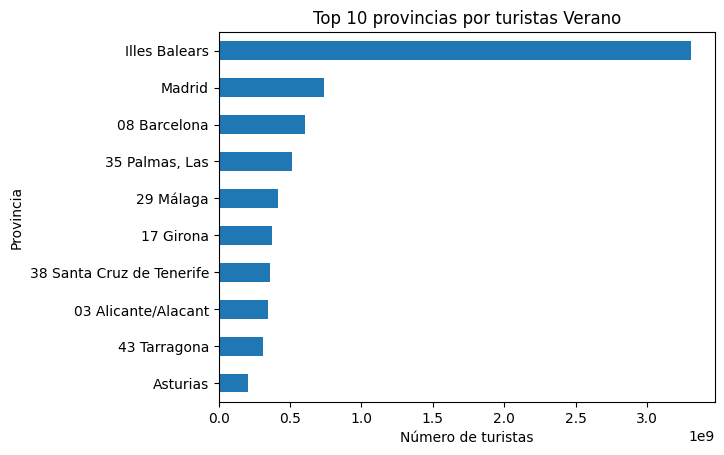

In [56]:
top_verano_revisado.plot(kind='barh', x='provincia', y='total_eoh', legend=False)
plt.gca().invert_yaxis()
plt.title("Top 10 provincias por turistas Verano")
plt.xlabel("Número de turistas")
plt.ylabel("Provincia")
plt.show()

In [57]:
top_invierno_revisado = (
    df_temporada[df_temporada['temporada'] == 'invierno']
    .sort_values('total_eoh', ascending=False)
    .head(10)
)
top_invierno_revisado

,provincia,temporada,total_eoh
192,Madrid,invierno,642026800.0
112,"35 Palmas, Las",invierno,436125422.0
124,38 Santa Cruz de Tenerife,invierno,333109419.0
24,08 Barcelona,invierno,275827564.0
184,Illes Balears,invierno,198156518.0
8,03 Alicante/Alacant,invierno,162282285.0
100,29 Málaga,invierno,154110489.0
132,41 Sevilla,invierno,79988600.0
64,18 Granada,invierno,79006766.0
152,46 Valencia/València,invierno,76749105.0


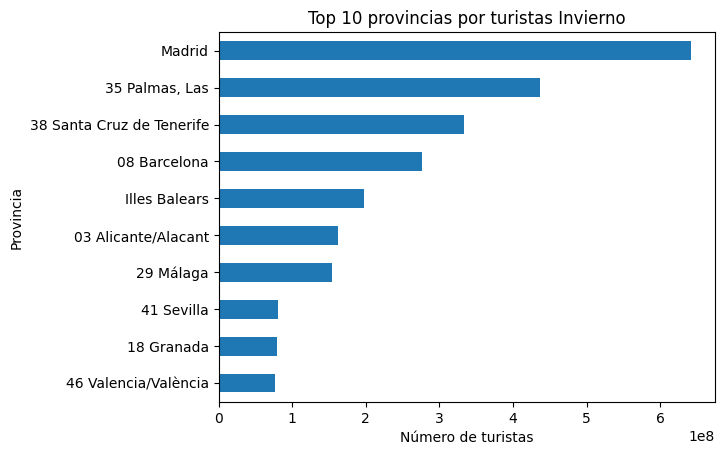

In [58]:
top_invierno_revisado.plot(kind='barh', x='provincia', y='total_eoh', legend=False)
plt.gca().invert_yaxis()
plt.title("Top 10 provincias por turistas Invierno")
plt.xlabel("Número de turistas")
plt.ylabel("Provincia")
plt.show()

En el otro dataframe, 

In [59]:

df_tmov.head()

,provincia_origen,provincia_origen_detalle,provincia_destino,provincia_destino_detalle_1,provincia_destino_detalle_2,concepto_turistico,periodo,num_turistas,provincia_final,año,mes,temporada
0,Total Nacional,NaN,Total Nacional,NaN,NaN,Turistas,2025M08,NaN,Total Nacional,2025,8,verano
1,Total Nacional,NaN,Total Nacional,NaN,NaN,Turistas,2025M07,NaN,Total Nacional,2025,7,verano
2,Total Nacional,NaN,Total Nacional,NaN,NaN,Turistas,2025M06,NaN,Total Nacional,2025,6,verano
3,Total Nacional,NaN,Total Nacional,NaN,NaN,Turistas,2025M05,NaN,Total Nacional,2025,5,primavera
4,Total Nacional,NaN,Total Nacional,NaN,NaN,Turistas,2025M04,NaN,Total Nacional,2025,4,primavera


In [60]:
df_temporada = (
    df_tmov 
    .groupby(['provincia_destino_detalle_1', 'temporada'], as_index=False)
    .agg({'num_turistas': 'sum'})
)

df_temporada.head()

,provincia_destino_detalle_1,temporada,num_turistas
0,Andalucía,invierno,1672029.964
1,Andalucía,otoño,1718172.031
2,Andalucía,primavera,1673206.090
3,Andalucía,verano,1758831.719
4,Aragón,invierno,707842.328


In [61]:
top_verano_revisado = (
    df_temporada[df_temporada['temporada'] == 'verano']
    .sort_values('num_turistas', ascending=False)
    .head(10)
)
top_verano_revisado

,provincia_destino_detalle_1,temporada,num_turistas
31,Castilla y León,verano,2370984.832
3,Andalucía,verano,1758831.719
27,Castilla - La Mancha,verano,1437803.882
51,Galicia,verano,1016541.845
35,Cataluña,verano,882286.154
71,País Vasco,verano,846974.316
7,Aragón,verano,828999.014
19,Canarias,verano,719988.098
47,Extremadura,verano,703469.705
75,"Rioja, La",verano,582999.058


In [62]:
df_tmov['provincia_destino'].unique()

array(['Total Nacional'], dtype=object)

In [63]:
df_tmov['provincia_destino_detalle_1'].unique()

array([nan, 'Andalucía', 'Aragón', 'Asturias, Principado de',
       'Balears, Illes', 'Canarias', 'Cantabria', 'Castilla y León',
       'Castilla - La Mancha', 'Cataluña', 'Comunitat Valenciana',
       'Extremadura', 'Galicia', 'Madrid, Comunidad de',
       'Murcia, Región de', 'Navarra, Comunidad Foral de', 'País Vasco',
       'Rioja, La', 'Ceuta', 'Melilla'], dtype=object)

In [64]:
df_tmov['provincia_destino_detalle_2'].unique()

array([nan, 'Almería', 'Cádiz', 'Córdoba', 'Granada', 'Huelva', 'Jaén',
       'Málaga', 'Sevilla', 'Huesca', 'Teruel', 'Zaragoza', 'Asturias',
       'Balears, Illes', 'Palmas, Las', 'Santa Cruz de Tenerife',
       'Cantabria', 'Ávila', 'Burgos', 'León', 'Palencia', 'Salamanca',
       'Segovia', 'Soria', 'Valladolid', 'Zamora', 'Albacete',
       'Ciudad Real', 'Cuenca', 'Guadalajara', 'Toledo', 'Barcelona',
       'Girona', 'Lleida', 'Tarragona', 'Alicante/Alacant',
       'Castellón/Castelló', 'Valencia/València', 'Badajoz', 'Cáceres',
       'Coruña, A', 'Lugo', 'Ourense', 'Pontevedra', 'Madrid', 'Murcia',
       'Navarra', 'Araba/Álava', 'Bizkaia', 'Gipuzkoa', 'Rioja, La',
       'Ceuta', 'Melilla'], dtype=object)